In [130]:
import os
import json
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


DIGIT_MAPPING = {
    0: 'zero',
    1: 'one',
    2: 'two',
    3: 'three',
    4: 'four',
    5: 'five',
    6: 'six',
    7: 'seven',
    8: 'eight',
    9: 'nine'
}

In [4]:
def parse_result(path):
    line_list = open(path,'r').readlines()
    lines = [line.strip() for line in line_list]
    end_line = lines[-1].split(', ')
    best_eer = end_line[-1].split(' ')[-1]
    result = {}
    sum_minDCF = 0
    for i,line in enumerate(lines):
        try:
            cur_eer = line.split(', ')[-2].split(' ')[-1]
            cur_best_eer = line.split(', ')[-1].split(' ')[-1]
            if cur_eer == cur_best_eer == best_eer:
                for j in range(i-2,i):
                    splits = lines[j].split(', ')
                    gender = splits[0].split(' ')[-1]
                    eer = splits[1].split(' ')[-1]
                    minDCF = splits[2].split(' ')[-1]
                    result[gender] = {'eer': float(eer.split('%')[0]), 'minDCF': float(minDCF)}
                    sum_minDCF += float(minDCF)
        except :
            pass
    result['overall'] = {'eer': float(best_eer.split('%')[0]), 'minDCF': sum_minDCF/2}
    return result


In [4]:
LOOP = 5

In [4]:
for l in range(LOOP):
    files = glob.glob('./checkpoints_combine/exp3/loop%s/*/score-stage.txt'%(l+1))
    for file in files:
        result = parse_result(file)
        index = file.rfind('/')
        path = file[:index]
        name = 'dev_results.json'
        with open(os.path.join(path, name), 'w') as f:
            json.dump(result,f)

In [140]:
def concate_result(files, loop, store=False):
    data = {
        'phase': [],
        'eer': [],
        'gender': [],
        'minDCF': [],
        'text': [],
        'loop': [],
        'word': []
        }
    parse = files[0].split('/')
    path = '/'.join(parse[:-2])
    for file in files:
        res = json.load(open(file, 'r'))
        splits = file.split('/')
        if 'eval' in splits[-1]:
            phase = 'eval'
        if 'dev' in splits[-1]:
            phase = 'dev'
        if 'all' in splits[-1]:
            phase ='eval'
        text = splits[-2]
        word = text.split('_')[0]
        
        for g in res:
            data['gender'].append(g)
            data['eer'].append(res[g]['eer'])
            data['minDCF'].append(res[g]['minDCF'])
            data['phase'].append(phase)
            data['text'].append(text)
            data['loop'].append(loop)
            data['word'].append(word)
    df = pd.DataFrame(data)
    if store:
        save_path = os.path.join(path, 'all_eval_results_real_data_and_fake_data_no_tuning.csv')
        print('Save result to %s' % (save_path))
        df.to_csv(save_path, index=False)
    return df

In [146]:
for l in [0]:
    result_files = glob.glob('pretrained_checkpoints/exp3/loop%s/*/all_eval_results_real_data_and_fake_data_no_tuning.json'%(l+1))
    df = concate_result(result_files,l+1,store=True)

Save result to pretrained_checkpoints/exp3/loop1/all_eval_results_real_data_and_fake_data_no_tuning.csv


In [55]:
result_files = glob.glob('experiment_checkpoints/exp3/*/all_eval_results_tuning_2.json')
df = concate_result(result_files,2,store=True)

Save result to experiment_checkpoints/exp3/all_eval_results_tuning_2.csv


In [9]:
def plot_result(df_all, gender, phase, loop):
    import matplotlib.pyplot as plt
    result = df_all[(df_all['phase'] == phase) & (df_all['gender'] == gender)].sort_values('word')
    # print(result) 
    text = [str(x) for x in range(0,10)]
    plt.figure(figsize=(12,6))
    plt.suptitle('%s - Iteration %s' % (gender, loop))

    plt.subplot(1,2,1)
    plt.bar(text, result['minDCF'],0.4, label='minDCF')
    plt.xticks(ticks=text)
    plt.xlabel('Text')
    plt.ylabel('minDCF')
    
    plt.subplot(1,2,2)
    plt.bar(text, result['eer'],0.4, label='EER')
    plt.xticks(ticks=text)
    plt.xlabel('Text')
    plt.ylabel('EER (%)')
    plt.show()
    

In [138]:
def get_result(data,max_loop=3):
    result = {
    }
    genders = ['female', 'male', 'all']
    phases = ['eval']
    words = [x for x in range(0,10)]
    for phase in phases:
        result[phase] = {}
        for gender in genders:
            result[phase][gender] = {
                'eer': {},
                'minDCF': {},
            }
            for word in words:
                df = data[(data['phase'] == phase) & (data['gender'] == gender) & (data['word']==word)]
                # print(data['word'])
                # print(df)
                result[phase][gender]['eer'][word] = df['eer'].to_list()
                result[phase][gender]['minDCF'][word] = df['minDCF'].to_list()
    return result

                

    

In [31]:
def get_result_2(data,max_loop=3):
    result = {
    }
    genders = ['female', 'male', 'all']
    phases = ['eval']
    # words = [x for x in range(0,10)]
    from itertools import permutations
    words = list(permutations(['9', '6', '3', '0','1'],r=2))
    words = ['_'.join(list(pair)) for pair in words]
    for phase in phases:
        result[phase] = {}
        for gender in genders:
            result[phase][gender] = {
                'eer': {},
                'minDCF': {},
            }
            for word in words:
                df = data[(data['phase'] == phase) & (data['gender'] == gender) & (data['word']==word)]
                # print(data['word'])
                # print(df)
                result[phase][gender]['eer'][word] = df['eer'].to_list()
                result[phase][gender]['minDCF'][word] = df['minDCF'].to_list()
    return result


In [30]:
json.dump(result, open('experiment_checkpoints/result_evals_tuning_2.json', 'w'))

In [172]:
df_all = pd.DataFrame()
MAX_LOOP = 5
for loop in range(2,MAX_LOOP+1):
    df_all = pd.concat([df_all, pd.read_csv('new_data_checkpoints/exp1/loop%s/all_eval_results_real_data_and_fake_data_tuning.csv'%(loop))], ignore_index=True)
result = get_result(df_all, max_loop=5)

In [173]:
json.dump(result, open('real_data_result/fake/exp1_real_data_and_fake_data_tuning.json', 'w'))

In [59]:
def show_result(result, metric='eer',all=False, start_loop=1, end_loop=5):
    if all:
        genders = ['overall']
    else:
        genders =  ['female','male','all']
    for gender in genders:
        # plt.figure(figsize=(12,4))
        name_set = list(result.keys())
        a = []
        # for v in result['dev'][gender][metric].values():
        #     a.extend(v)
        for v in result['eval'][gender][metric].values():
            a.extend(v)
        if len(a) == 0:
            continue
        min_ = min(a)
        max_ = max(a)
        for idx,set in enumerate(name_set):
            ax = plt.subplot(len(name_set),1,idx+1)
            set_result = result[set]
            for i in range(0,10):
                try:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][i])
                except:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][str(i)])

            # box = ax.get_position()
            # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            plt.xticks([ i for i in range(start_loop,end_loop+1)])
            plt.xlabel('The times of iteration')
            plt.ylim((min_-1,max_+1))
            plt.ylabel('EER (%)')
            plt.title(gender.capitalize())
        plt.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper right', bbox_to_anchor=(1.15, 1))
        # plt.savefig('results/output_exp1_%s.png'%(gender))

In [196]:
result = {}
result['0'] = json.load(open('real_data_result/fake/real_data_and_fake_data_tuning_loop1.json', 'r'))
result['1'] = json.load(open('real_data_result/fake/exp1_real_data_and_fake_data_tuning.json', 'r'))
result['2'] = json.load(open('real_data_result/fake/exp2_real_data_and_fake_data_tuning.json', 'r'))
result['3'] = json.load(open('real_data_result/fake/exp3_real_data_and_fake_data_tuning.json', 'r'))


In [197]:
MAX_LOOP = 5
phases = ['eval']
metrics = ['eer', 'minDCF']
genders = ['female', 'male', 'all']
final_result = {}
# word = {}
for phase in phases:
    final_result[phase] = {}
    # word[phase] = {}
    for gender in genders:
        final_result[phase][gender] = {}
        # word[phase][gender] = {}
        for metric in metrics:
            final_result[phase][gender][metric] = {}
            # word[phase][gender][metric] = {}
            for i in range(0,10):
                temp = []
                for exp in result:
                    if exp == '0':
                        continue
                    temp.append(result[exp][phase][gender][metric][str(i)][:MAX_LOOP])
                value = np.mean(temp, axis=0)
                # final_result[phase][gender][metric][i] = list(value)
                final_result[phase][gender][metric][i] = result['0'][phase][gender][metric][str(i)] + list(value)
                # word[phase][gender][metric][i] = value[0]






In [198]:
json.dump(final_result, open('real_data_result/fake/real_data_and_fake_data_tuning.json', 'w'))

In [101]:
final_result = json.load(open('real_data_result/real_data_tw_tuning.json', 'r'))

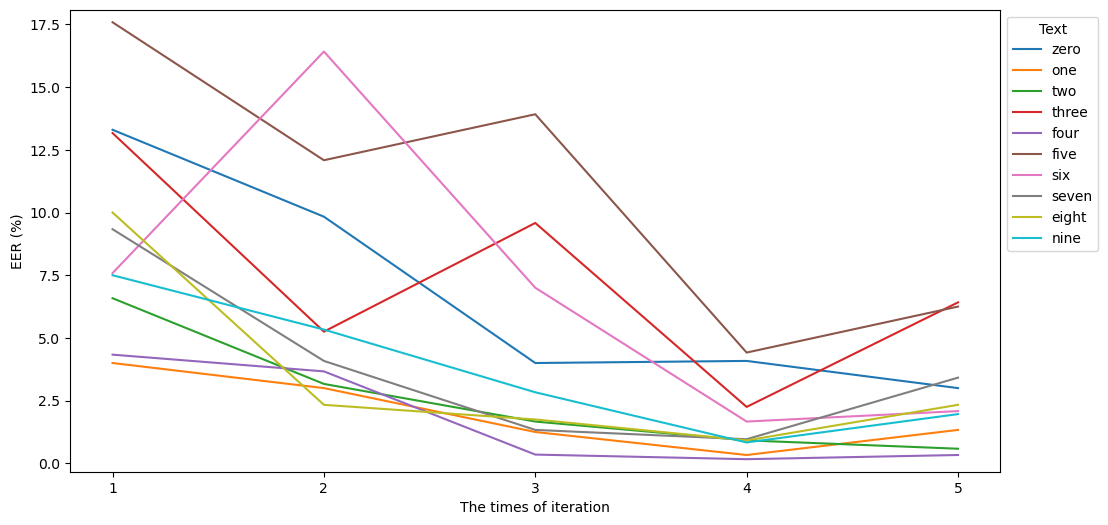

In [199]:
start_loop = 1
end_loop = 5
genders =  ['male']
metric = 'eer'
# fig = plt.figure(figsize=(14,6))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.8,
#                     top=1,
#                     wspace=0.2,
#                     hspace=0.4)
# spec = fig.add_gridspec(2, 2)

a = []
for gender in genders:
    for v in final_result['eval'][gender][metric].values():
            a.extend(v)
    if len(a) == 0:
        continue
    min_ = min(a)
    max_ = max(a)

for i, gender in enumerate(genders):
    # plt.figure(figsize=(12,4))
    name_set = list(final_result.keys())
    # for v in result['dev'][gender][metric].values():
    #     a.extend(v)
    # if gender=='all':
        # ax = plt.subplot2grid((2,4),(1,1), colspan=2)
    # ax = fig.add_subplot(2,2,i+1)
        # ax.set_adjustable('box'=[1.5,1.5,6,4])
    # if gender == 'female':
        # ax = plt.subplot2grid((2,4),(0,0), colspan=2)
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    # if gender == 'male':
        # ax = plt.subplot2grid((2,4),(0,2), colspan=2)
    for idx,set in enumerate(name_set):
        set_result = final_result[set]
        # print(set_result[gender][metric])
        for i in range(0,10):
            try:
                ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][i])
            except:
                ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][str(i)])

        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.set_xticks([ i for i in range(start_loop,end_loop+1)])
    ax.set_xlabel('The times of iteration')
    ax.set_ylim((min_-0.5,max_+0.5))
    if metric == 'eer':
        y_label = 'EER (%)'
    else:
        y_label = 'minDCF'

    ax.set_ylabel(y_label)
    ax.set_title('')
    ax.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
    # ax.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=2, bbox_to_anchor=[1.2,1], title='Text')
plt.show()

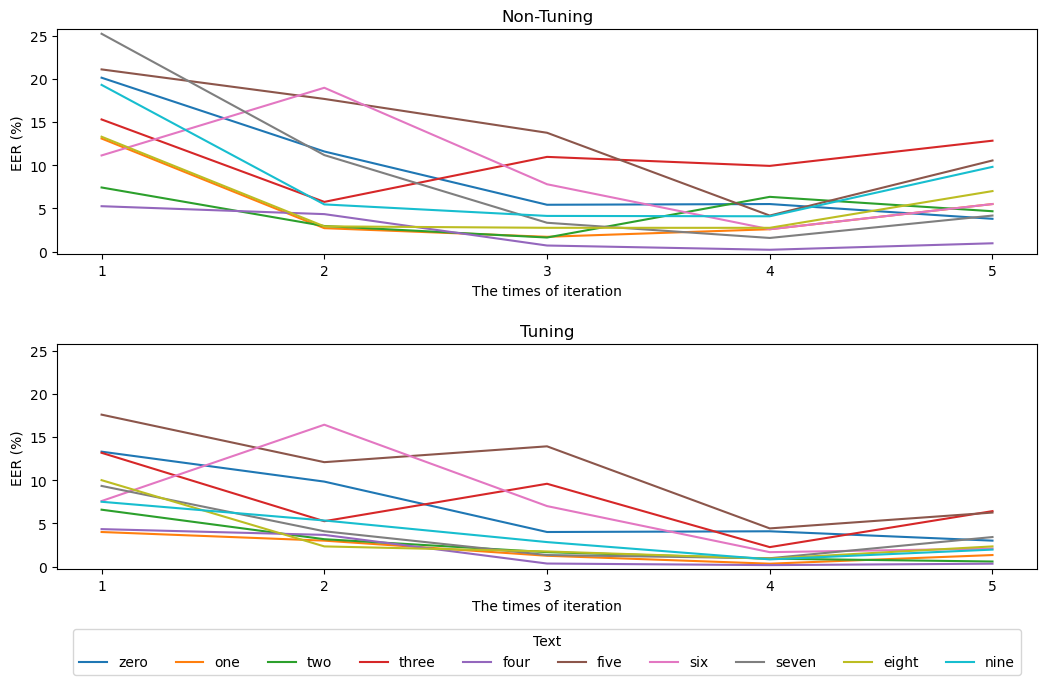

In [200]:
final_results = [json.load(open('real_data_result/fake/real_data_and_fake_data_no_tuning.json', 'r')),
                 json.load(open('real_data_result/fake/real_data_and_fake_data_tuning.json', 'r'))]
result_labels = ['Non-Tuning', 'Tuning']
start_loop = 1
end_loop = 5
genders =  ['male']
metric = 'eer'

a = []
for final_result in final_results:
    for gender in genders:
        for v in final_result['eval'][gender][metric].values():
                a.extend(v)
        if len(a) == 0:
            continue
        min_ = min(a)
        max_ = max(a)
fig = plt.figure(figsize=(14,6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.8,
                    top=1,
                    wspace=0.2,
                    hspace=0.4)
# spec = fig.add_gridspec(2, 2)
for case_idx, final_result in enumerate(final_results):
    ax = fig.add_subplot(2,1,case_idx+1)
    for i, gender in enumerate(genders):
        # plt.figure(figsize=(12,4))
        name_set = list(final_result.keys())
        # for v in result['dev'][gender][metric].values():
        #     a.extend(v)
        # if gender=='all':
            # ax = plt.subplot2grid((2,4),(1,1), colspan=2)
        # 
            # ax.set_adjustable('box'=[1.5,1.5,6,4])
        # if gender == 'female':
            # ax = plt.subplot2grid((2,4),(0,0), colspan=2)
        # fig = plt.figure(figsize=(12,6))
        # ax = fig.add_subplot(111)
        
        # if gender == 'male':
            # ax = plt.subplot2grid((2,4),(0,2), colspan=2)
        for idx,set in enumerate(name_set):
            set_result = final_result[set]
            # print(set_result[gender][metric])
            for i in range(0,10):
                try:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][i])
                except:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][str(i)])

            # box = ax.get_position()
            # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.set_xticks([ i for i in range(start_loop,end_loop+1)])
        ax.set_xlabel('The times of iteration')
        ax.set_ylim((min_-0.5,max_+0.5))
        if metric == 'eer':
            y_label = 'EER (%)'
        else:
            y_label = 'minDCF'

    ax.set_ylabel(y_label)
    ax.set_title(result_labels[case_idx])
plt.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='lower center', ncol=10, bbox_to_anchor=[0.5,-0.5], title='Text')
        # ax.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=2, bbox_to_anchor=[1.2,1], title='Text')
plt.show()

# Compare 6-6 to other

In [86]:
from itertools import permutations 
df_all = pd.DataFrame()
files = glob.glob('experiment_checkpoints/*/all_eval_results_tuning_2.csv')
for file in files:
    df_all = pd.concat([df_all, pd.read_csv(file)], ignore_index=True)
result = {
    }
genders = ['female', 'male', 'all']
phases = ['eval']
words = list(permutations(['9', '6', '3', '0','1'],r=2))
for phase in phases:
    result[phase] = {}
    for gender in genders:
        result[phase][gender] = {
            'eer': {},
            'minDCF': {},
        }
        for word in words:
            text = [str(w) for w in word]
            text = '_'.join(text)
            df = df_all[(df_all['phase'] == phase) & (df_all['gender'] == gender) & (df_all['text']==text)]
            # print(data['word'])
            result[phase][gender]['eer'][text] = np.mean(df['eer'].to_list())
            result[phase][gender]['minDCF'][text] = np.mean(df['minDCF'].to_list())


In [108]:

array = []
for i in range(0,10):
    temp = []
    for gender in ['female','male','all']:
        temp.append(final_result['eval'][gender]['eer'][i][0])
    array.append(temp)
    print(temp)
avg = np.mean(array,axis=1)
avg # 1 3 6 9

[2.2020861678004526, 2.68298185941043, 2.748888888888889]
[2.8000000000000003, 3.059251700680271, 3.152380952380952]
[2.5449433106575934, 3.7935260770975074, 3.4612244897959186]
[1.5751927437641724, 2.3171768707483, 2.1945306122448978]
[5.394965986394559, 2.779467120181406, 3.271383219954649]
[3.6466666666666665, 2.2698412698412738, 2.7102040816326536]
[1.6780045351473891, 2.3961111111111113, 2.348480725623583]
[1.8140589569161019, 2.8272902494331054, 2.682494331065758]
[1.9062585034013602, 2.4416893424036292, 2.3266757369614517]
[3.7077551020408173, 2.353333333333333, 2.676825396825398]


array([2.54465231, 3.00387755, 3.26656463, 2.02896674, 3.81527211,
       2.87557067, 2.14086546, 2.44128118, 2.22487453, 2.91263794])

In [109]:
dir = {}
for i in range(len(avg)):
    dir[i] = avg[i]
{k: v for k, v in sorted(dir.items(), key=lambda item: item[1])}

{3: 2.028966742252457,
 6: 2.1408654572940278,
 8: 2.2248745275888138,
 7: 2.4412811791383215,
 0: 2.5446523053665904,
 5: 2.8755706727135313,
 9: 2.912637944066516,
 1: 3.0038775510204077,
 2: 3.26656462585034,
 4: 3.8152721088435375}

In [87]:
final_result = json.load(open('final_results/average_pretrained_diff_index.json', 'r'))

In [88]:
keys = ['0','1', '3', '6', '9']
filter = {}
for gender in ['female', 'male', 'all']:
    filter[gender] = {} 
    filter[gender]['eer'] = {}
    filter[gender]['minDCF'] = {}
    for digit in keys:
        filter[gender]['eer'][digit + '_' + digit] = final_result['eval'][gender]['eer'][digit][1]
        filter[gender]['minDCF'][digit +  '_' + digit] = final_result['eval'][gender]['minDCF'][digit][1]

In [89]:
filter

{'female': {'eer': {'0_0': 1.9302947845804992,
   '1_1': 3.033605442176869,
   '3_3': 2.1063492063492046,
   '6_6': 1.7978684807256229,
   '9_9': 3.714421768707482},
  'minDCF': {'0_0': 0.1352662131519283,
   '1_1': 0.20079410430838998,
   '3_3': 0.12232562358276657,
   '6_6': 0.12347029478458042,
   '9_9': 0.22140362811791336}},
 'male': {'eer': {'0_0': 3.2096371882086188,
   '1_1': 3.1749999999999994,
   '3_3': 2.4596712018140594,
   '6_6': 2.8371995464852593,
   '9_9': 2.553038548752834},
  'minDCF': {'0_0': 0.21672052154194985,
   '1_1': 0.2116066893424041,
   '3_3': 0.1785672335600906,
   '6_6': 0.19943990929705216,
   '9_9': 0.21636337868480685}},
 'all': {'eer': {'0_0': 3.1701315192743746,
   '1_1': 3.298947845804989,
   '3_3': 2.3646984126984134,
   '6_6': 2.7158367346938768,
   '9_9': 2.9255963718820848},
  'minDCF': {'0_0': 0.20276825396825401,
   '1_1': 0.22711492063492053,
   '3_3': 0.1662248526077091,
   '6_6': 0.18446312925170005,
   '9_9': 0.23195600907029448}}}

In [91]:
for gender in ['female', 'male', 'all']:
    filter[gender]['eer'].update(result['eval'][gender]['eer'])
    filter[gender]['minDCF'].update(result['eval'][gender]['minDCF'])
    

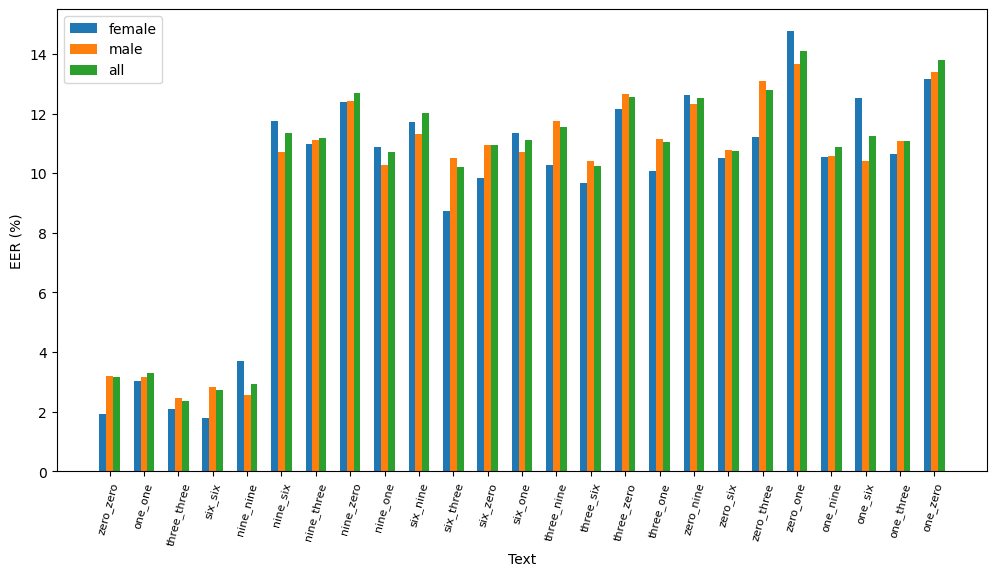

In [92]:
param = [-0.2, 0, +0.2]
plt.figure(figsize=(12,6))
# data_vis = dict(sorted(filter[gender][metric].items(), key=lambda item: item[1]))
plt.bar(np.arange(len(filter['female']['eer'])) - 0.2, list(filter['female']['eer'].values()),width=0.2)
plt.bar(np.arange(len(filter['male']['eer'])), list(filter['male']['eer'].values()),width=0.2)
plt.bar(np.arange(len(filter['all']['eer']))  +0.2, list(filter['all']['eer'].values()),width=0.2)
plt.xlabel('Text')
plt.ylabel('EER (%)')
plt.legend(['female', 'male', 'all'])
plt.xticks(ticks=range(len(filter['female']['eer'])),labels=[ '_'.join([DIGIT_MAPPING[int(i)] for i in text.split('_')]) for text in list(filter['female']['eer'].keys())],fontsize=8, rotation=75)
plt.show()
        # plt.savefig('experiment_checkpoints/%s.png' % (gender))

In [96]:
json.dump(filter, open('experiment_checkpoints/result_final.json', 'w'))

In [4]:
metrics = ['eer', 'minDCF']
words = ['6', '6_6']
result = {}
for gender in ['male','female','all']:
    result[gender] = {}
    for w in words:
        files = glob.glob('real_test/%s_*.json'%(w))
        if len(files) > 0:
            sum_eer = 0
            sum_minDCF = 0
            for file in files:
                scores = json.load(open(file))
                sum_eer += scores[gender]['eer']
                sum_minDCF += scores[gender]['minDCF']
            avg_eer = sum_eer / len(files)
            avg_minDCF = sum_minDCF / len(files)
            result[gender][w] = {'eer': avg_eer, 'minDCF':avg_minDCF}

In [8]:
json.dump(result, open('real_test/result.json','w'))

In [6]:
result['male']

{'6': {'eer': 9.513888888888888, 'minDCF': 0.3351851851851852},
 '6_6': {'eer': 7.638888888888889, 'minDCF': 0.2925925925925926}}

In [7]:
result

{'male': {'6': {'eer': 9.513888888888888, 'minDCF': 0.3351851851851852},
  '6_6': {'eer': 7.638888888888889, 'minDCF': 0.2925925925925926}},
 'female': {'6': {'eer': 9.1313882532418, 'minDCF': 0.3595209339774557},
  '6_6': {'eer': 5.207220950928044, 'minDCF': 0.21256038647342992}},
 'all': {'6': {'eer': 9.965277777777779, 'minDCF': 0.4131944444444444},
  '6_6': {'eer': 8.194444444444445, 'minDCF': 0.3833333333333333}}}

In [32]:
remove_files = glob.glob('new_data_checkpoints/*/*/*real_data*.csv')

In [35]:
for file in remove_files:
    os.remove(file)